### Problem 1
Compare parallel processing modules

In [1]:
from random import uniform
from math import sqrt
from time import time

import numpy as np
import scipy.stats as stats
import dask as da

from multiprocessing import Pool, Process

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def throw_dart(*args):
    x,y = uniform(0,1), uniform(0,1)
    if sqrt((x-0.5)**2+(y-0.5)**2) <= 0.5:
        return 1
    return 0

def throw_darts_serial(n):
    count = 0
    for i in range(n):
        count += throw_dart()
    return count

In [3]:
def throw_darts_mp_pool(n, njobs=4):
    pool = Pool(njobs)
    count = sum(pool.map(throw_dart,range(n)))
    return count

In [4]:
def throw_darts_da(n):
    values = [da.delayed(throw_dart)() for _ in range(n)]
    result = sum(da.compute(*values))
    return result

In [5]:
def throw_darts_np(n):
    x,y = np.random.uniform(0,1,n), np.random.uniform(0,1,n)
    r = np.sqrt((x-0.5)**2+(y-0.5)**2)
    return np.sum(r <= 0.5)

In [6]:
def time_trial(func,n):
    start = time()
    in_circle = func(n)
    end = time()
    exec_time = end-start
    pi_approx = 4*in_circle/n
    print('Pi Approx:', pi_approx)
    print('N Darts:', n)
    print('Execution Time (s):',exec_time)
    print('Darts per second:',n/exec_time)

### Serial Method

In [52]:
N = 200000
time_trial(throw_darts_serial,N)

Pi Approx: 3.14702
N Darts: 200000
Execution Time (s): 0.3180270195007324
Darts per second: 628877.3837958111


### Multiprocessing Pool Method

In [8]:
time_trial(throw_darts_mp_pool,N)

Pi Approx: 3.14434
N Darts: 200000
Execution Time (s): 0.1199951171875
Darts per second: 1666734.486266531


### Dask

In [40]:
time_trial(throw_darts_da,N)

Pi Approx: 3.14372
N Darts: 200000
Execution Time (s): 40.57863998413086
Darts per second: 4928.701407395966


### Numpy
Just for fun, since this will blow the others away

In [43]:
time_trial(throw_darts_np,10*N)

Pi Approx: 3.143494
N Darts: 2000000
Execution Time (s): 0.12531709671020508
Darts per second: 15959514.32409088


### Problem 2
Plot execution time vs darts thrown for each method

In [7]:
def running_trial(func,ndarts):
    maxdarts = np.max(ndarts)
    start = time()
    count = func(ndarts[0])
    exec_time = time()-start
    times = [exec_time]
    for i,n in enumerate(ndarts[1:]):
        count = func(n-ndarts[i])
        exec_time = time()-start
        if n in ndarts:
            times.append(exec_time)
    return times

In [8]:
def many_trials(func,ndarts,ntrials=20):
    trials = np.array([running_trial(func,ndarts) for _ in range(ntrials)])
    return trials
def mean_time(trials):
    return np.mean(trials,axis=0)
def ci_time(trials):
    low = stats.scoreatpercentile(trials,5,axis=0)
    high = stats.scoreatpercentile(trials,95,axis=0)
    return low,high

In [9]:
ndarts = np.logspace(0,6,5,dtype=int)
serial_times = running_trial(throw_darts_serial, ndarts)
mp_times = running_trial(throw_darts_mp_pool, ndarts)
np_times = running_trial(throw_darts_np, ndarts)

In [10]:
da_times = running_trial(throw_darts_da, ndarts)

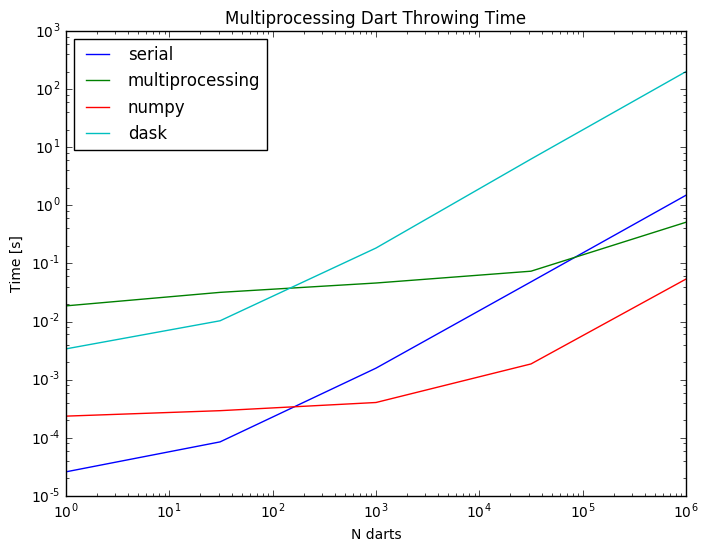

In [11]:
plt.figure(figsize=(8,6))
plt.loglog(ndarts,serial_times, label='serial')
plt.loglog(ndarts,mp_times, label='multiprocessing')
plt.loglog(ndarts,np_times, label='numpy')
plt.loglog(ndarts,da_times, label='dask')
plt.legend(loc=2)
plt.title('Multiprocessing Dart Throwing Time')
plt.ylabel('Time [s]')
plt.xlabel('N darts')
plt.savefig('plots/dart-exectime.png')
plt.show()

In [12]:
serial_times = many_trials(throw_darts_serial, ndarts)
mp_times = many_trials(throw_darts_mp_pool, ndarts)
np_times = many_trials(throw_darts_np, ndarts)

In [13]:
da_times = many_trials(throw_darts_da, ndarts)

In [14]:
serial_mean = mean_time(serial_times)
serial_low, serial_high = ci_time(serial_times)
mp_mean = mean_time(mp_times)
mp_low, mp_high = ci_time(mp_times)
np_mean = mean_time(np_times)
np_low, np_high = ci_time(np_times)
da_mean = mean_time(da_times)
da_low, da_high = ci_time(da_times)

In [21]:
serial_rate = ndarts/serial_mean
mp_rate = ndarts/mp_mean
np_rate = ndarts/np_mean
da_rate = ndarts/da_mean

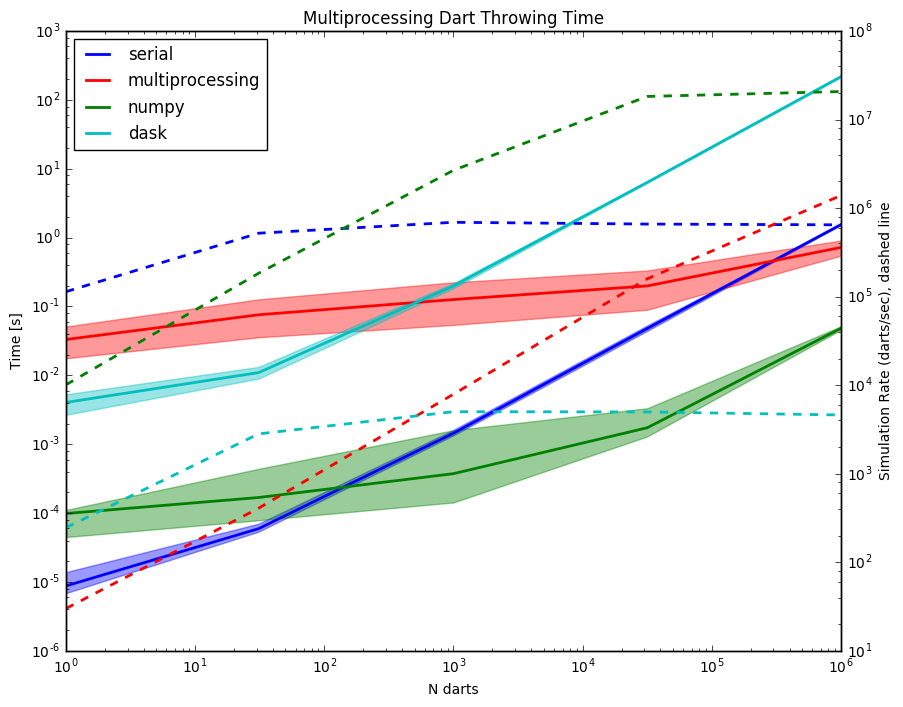

In [24]:
fig,ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)

ax1.loglog(ndarts,serial_mean, linewidth=2, label='serial', color='b')
ax1.fill_between(ndarts,serial_low,serial_high,alpha=0.4, color='b')

ax1.loglog(ndarts,mp_mean,linewidth=2, label='multiprocessing', color='r')
ax1.fill_between(ndarts,mp_low,mp_high,alpha=0.4, color='r')

ax1.loglog(ndarts,np_mean,linewidth=2, label='numpy',color='g')
ax1.fill_between(ndarts,np_low,np_high,alpha=0.4, color='g')

ax1.loglog(ndarts,da_mean,linewidth=2, label='dask',color='c')
ax1.fill_between(ndarts,da_low,da_high,alpha=0.4, color='c')

plt.title('Multiprocessing Dart Throwing Time')
ax1.set_ylabel('Time [s]', color='k', fontsize='medium')
ax1.set_xlabel('N darts', color='k', fontsize='medium')
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.set_ylabel('Simulation Rate (darts/sec), dashed line', color='k',fontsize='medium')
ax2.loglog(ndarts,serial_rate, linestyle='--', linewidth=2, label='serial', color='b')
ax2.loglog(ndarts,mp_rate, linestyle='--', linewidth=2, label='multiprocessing', color='r')
ax2.loglog(ndarts,np_rate, linestyle='--', linewidth=2, label='numpy', color='g')
ax2.loglog(ndarts,da_rate, linestyle='--', linewidth=2, label='dask', color='c')

plt.savefig('plots/dart-exectime-ci.png')
plt.show()